In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re
import numpy as np
from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# plt.style.use('ggplot')

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'dracula', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
folder = '.'

test_types = ['IV']
all_data = {}
for ttype in test_types:
    # recursively search the folder for excel files starting with ttype
    t, d,l = read_1t1r_data(folder, ttype)

    # sort the data by temerature and store it
    all_data[ttype] = sorted(list(zip(t,d)), key=lambda x:x[0])
    
    print(f"Found {len(d)} {ttype} Tests across {len(np.unique(t))} temperatures")

Found 30 IV Tests across 1 temperatures


In [3]:
all_data['IV'][0]

(300,
 array([[ 4.99544e-02,  3.21614e-07],
        [ 9.99574e-02,  6.60773e-07],
        [ 1.49951e-01,  1.03747e-06],
        ...,
        [-1.00056e-01, -6.44402e-07],
        [-5.00618e-02, -3.08856e-07],
        [-3.10898e-05, -8.44278e-10]]))

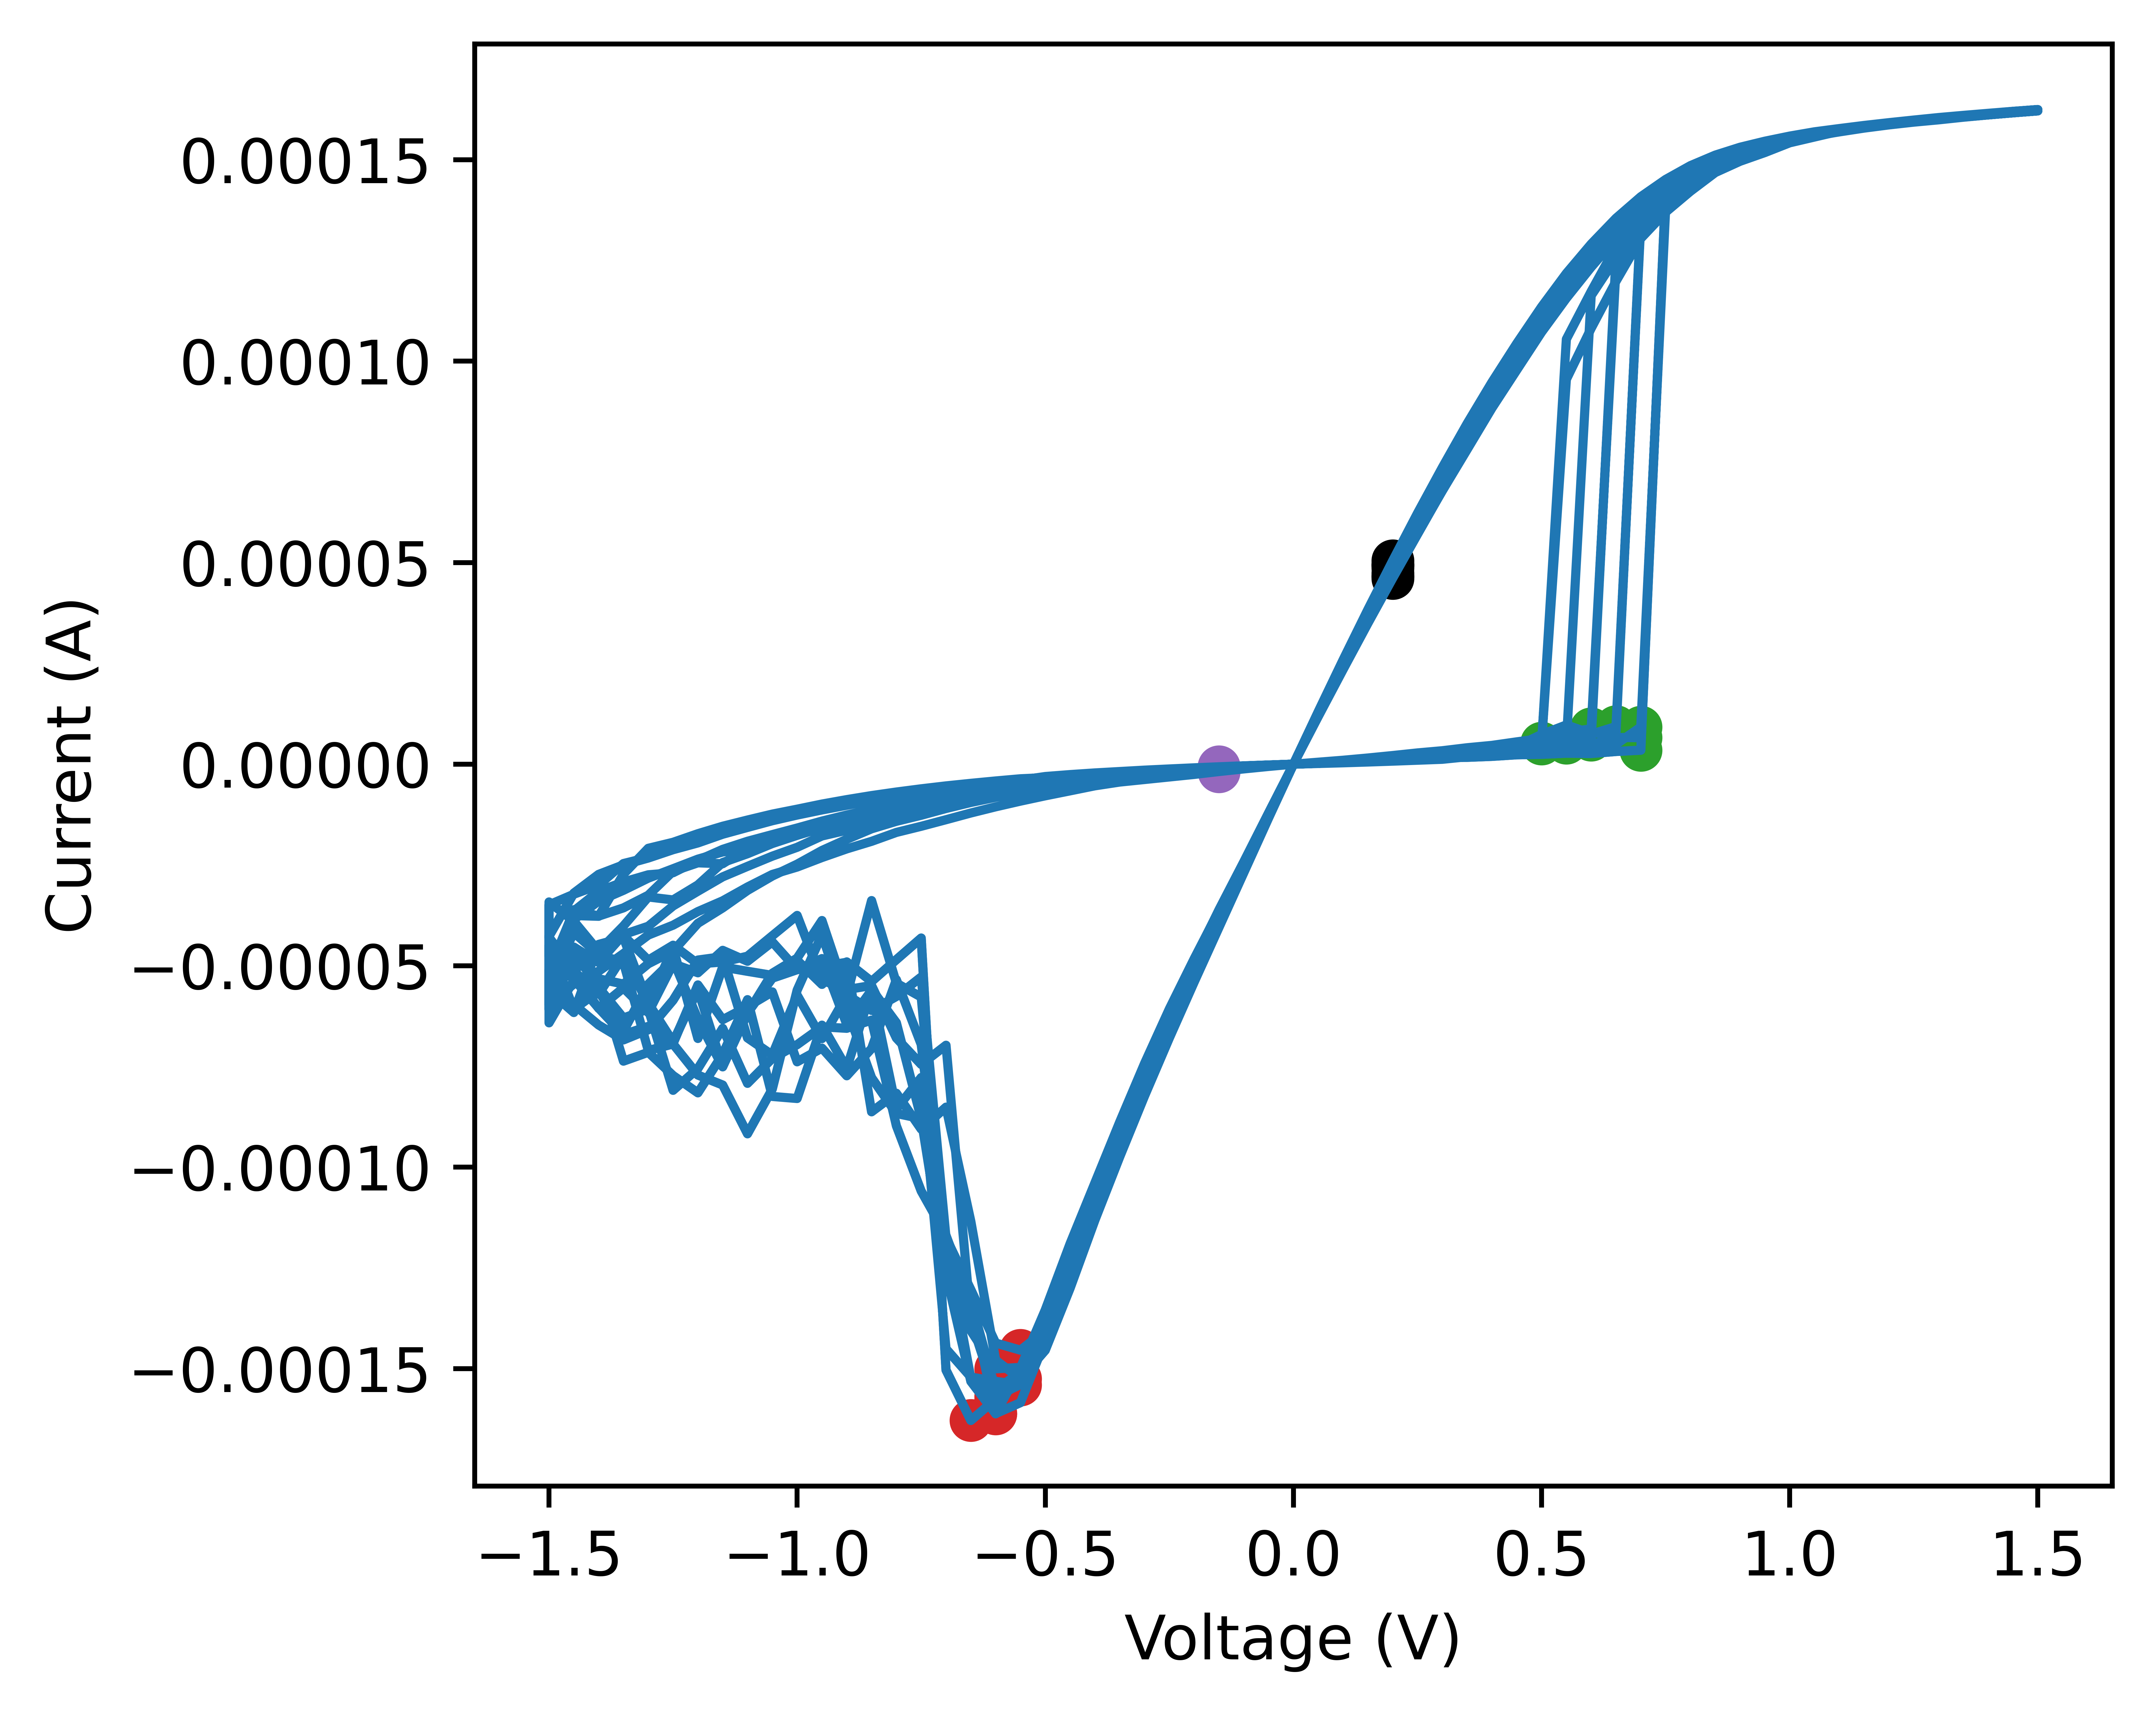

Set + Reset Operations have been tested 10 times on 1 devices
Set Voltage:
	mean: 0.6149888 Volts
	std: 0.07432729184061533 Volts
Reset Voltage:
	mean: -0.5900730999999999 Volts
	std: 0.02998920117792402 Volts
Set Resistance:
	mean: 3697.4301699664475 Ohms
	std: 119.67250855424437 (3.24%)Ohms
Reset Resistance:
	mean: 143266.91236494825 Ohms
	std: 41137.82584299387 (28.71%)Ohms


In [8]:
# analyze memristor as if it's a state machine
plot_iv = True
idx_to_ignore = [24, 6] # I got this by looking at the iv plots for bad memristors

# 2D lists 
# the first dimension is devices
# the second is the LRS/HRS values of each i/v sweep
LRS = []
HRS = []

all_min_vs = [] #minimum voltage reached during a sweep
all_set_vs = [] #set voltages
all_reset_vs = [] #reset voltages

read_v = 0.2 #voltage at which to 'read' LRS/HRS resitances
n_read_points = 8 # number of points to average  LRS/HRS

# threshold for determining when a set has occured
set_multiple_difference = 50

for idx, d in enumerate(all_data['IV']):
    if idx != 0:
        continue
    if idx in idx_to_ignore:
        continue

    current = []
    voltage = []
    for j, p in enumerate(d[1]):

        current.append(p[1])
        voltage.append(p[0])

    curr_LRS = []
    curr_HRS = []

    sweeps_v = []
    sweeps_i = []
    sweeps_v.append([])
    sweeps_i.append([])

    state = 'check_set'
    min_vs = []
    min_is = []
    set_vs = []
    reset_vs = []
    set_is = []
    test_is = []
    test_vs = []
    HRS_measure_is = []
    HRS_measure_vs = []
    LRS_measure_is = []
    LRS_measure_vs = []
    reset_is = []
    read_resistances = []
    last_resistance = voltage[0]/current[0]
    last_v = voltage[0]
    last_i = current[0]
    last_x_is = []
    last_x_vs = []
    len_is = 8

    for v, i in zip(voltage, current):
        sweeps_i[-1].append(i)
        sweeps_v[-1].append(v)
        resistance = v/i
        # print(f'{state} {v} {min_vs} {read_resistances} {resistance} {last_resistance} {i} {min_is}')
        last_x_is.append(i)
        if len(last_x_is) > len_is:
            last_x_is.pop(0)
        last_x_vs.append(v)
        if len(last_x_vs) > len_is:
            last_x_vs.pop(0)

        if state=='check_set':
            # this is the messiest thing in here I swear
            if (len(last_x_is) == len_is and i > set_multiple_difference*np.mean(np.abs(last_x_is[0:4]))) or i > 0.00005 or v > 1:
                min_vs.append(None)
                set_vs.append(last_v)
                set_is.append(last_i)
                test_is.append(last_x_is[0])
                test_vs.append(last_x_vs[0])
                state='read_lrs'
                last_5_is = []
        elif state=='read_lrs' and v < read_v:

            read_resistances.append(resistance)

            if len(read_resistances) == 1:
                LRS_measure_is.append(i)
                LRS_measure_vs.append(v)
            if len(read_resistances) >= n_read_points:

                curr_LRS.append(np.mean(read_resistances))
                read_resistances = []
                state = 'check_reset'
                min_is.append(i)
                # break
        elif state=='check_reset':
            if min_is[-1] < i:
                reset_vs.append(last_v)
                reset_is.append(last_i)
                state = 'find_min_v'
                # break
            else:
                min_is[-1] = i
        elif state=='find_min_v':
            if min_vs[-1] is not None:
                if v > min_vs[-1]: # we are going back up in voltage, we got the min_v for this sweep
                    state = 'read_hrs'
                else: # we are still going down, we don't have the min_v for this sweep
                    min_vs[-1] = np.round(v,3)
            elif min_vs[-1] is None:
                min_vs[-1] = v
        elif state=='read_hrs' and v > -read_v:
            read_resistances.append(resistance)

            if len(read_resistances) == 1:
                HRS_measure_is.append(i)
                HRS_measure_vs.append(v)

            if len(read_resistances) >= n_read_points:
                
                curr_HRS.append(np.mean(read_resistances))
                state='check_set'
                read_resistances = []

                sweeps_v.append([])
                sweeps_i.append([])

        last_resistance = resistance
        last_v = v
        last_i = i

    

    # add in the last one resistance level depending on what state we were last in
    if state=='read_hrs' and len(read_resistances) >0:
        curr_HRS.append(np.mean(read_resistances))
    elif state=='read_lrs' and len(read_resistances) >0:
        curr_LRS.append(np.mean(read_resistances))

    if plot_iv:
        idx_test = 2

        fig = plt.subplots(1,1,figsize=(5,4), dpi=1600)
        # plt.plot(sweeps_v[idx_test], 1/np.gradient(sweeps_i[idx_test]))
        # sweeps_i[idx_test].append(sweeps_i[idx_test][0])
        # sweeps_v[idx_test].append(sweeps_v[idx_test][0])
        plt.plot(sweeps_v[idx_test], np.asarray(sweeps_i[idx_test]), color='tab:blue')
        plt.plot(voltage, np.asarray(current), color='tab:blue')
        plt.scatter(set_vs, set_is, color='tab:green', label='Set Voltage')
        # plt.scatter(test_vs, test_is, color='tab:orange', label='Set Voltage Reference')
        plt.scatter(reset_vs, reset_is, color='tab:red', label='Reset Voltage')
        plt.scatter(HRS_measure_vs, HRS_measure_is, color='tab:purple', label='HRS Measure Begin')
        plt.scatter(LRS_measure_vs, LRS_measure_is, color='k', label='LRS Measure Begin')
        # plt.title(f'{idx}')
        plt.ylabel('Current (A)')
        plt.xlabel('Voltage (V)')
        # plt.yscale('log')
        # plt.legend()
        plt.show()

    # print(min_vs)
    all_min_vs.append(np.asarray(min_vs))
    all_set_vs.append(set_vs)
    all_reset_vs.append(reset_vs)
    # break
    LRS.append(np.asarray(curr_LRS))
    HRS.append(np.asarray(curr_HRS))
        

print(f'Set + Reset Operations have been tested {len(LRS[0])} times on {len(all_min_vs)} devices')
print(f'Set Voltage:\n\tmean: {np.mean(all_set_vs)} Volts\n\tstd: {np.std(all_set_vs)} Volts')
print(f'Reset Voltage:\n\tmean: {np.mean(all_reset_vs)} Volts\n\tstd: {np.std(all_reset_vs)} Volts')
print(f'Set Resistance:\n\tmean: {np.mean(LRS)} Ohms\n\tstd: {np.std(LRS)} ({(np.std(LRS)/ np.mean(LRS))*100:.2f}%)Ohms')
print(f'Reset Resistance:\n\tmean: {np.mean(HRS)} Ohms\n\tstd: {np.std(HRS)} ({(np.std(HRS)/ np.mean(HRS))*100:.2f}%)Ohms')

# print(np.std(HRS, axis=0))


